In [1]:
# ------------------------------------------------
# Importing Libraries
# ------------------------------------------------
import sys
import os
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
import random
import time
import math
from collections import deque
import collections
import pickle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import permutations


import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
# Replace both sets of Keras imports with:
from tensorflow.keras import Sequential, layers, optimizers
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

In [2]:
import numpy as np
import random
from itertools import permutations

# Defining hyperparameters
m = 5           # number of zones
t = 24          # hours per day
d = 7           # days per week
C = 5         # per-hour cost
R = 9           # per-hour revenue

# Infinite-horizon sale/maintenance parameters
SELL_PRICE = 80          # fixed sell offer for debugging
OFFER_PROB = 0.4          # probability of an offer when sellable
DETERIORATION_PROB = 0.1   # per-step chance taxi becomes damaged
REPAIR_PROB = 0.5           # chance maintenance restores sellable state
MAINTENANCE_COST = 50       # cost to perform maintenance
RENT_PER_STEP   = 6         # what you’d earn per time unit if you literally rented out
# compute the infinite‐horizon discounted sum:
GAMMA=0.99
RENT_LUMP_SUM   = RENT_PER_STEP / (1.0 - GAMMA)

# Load travel-time matrix
Time_matrix = np.load("/kaggle/input/rl-project/TM.npy")
log_dir = "/kaggle/working/tf_logs"   

class CabDriver:
    """Infinite-horizon taxi environment with sell and maintenance actions."""
    def __init__(self):
        # action_space: sell, idle, maintain, then all possible rides
        self.action_space = ['sell','idle','maintain','rent'] + list(permutations(range(m), 2))
        # self.action_space = ['sell','idle','maintain','rent'] + list(permutations(range(m),2))
        self.state_size = m + t + d + 2
        self.reset()

    def reset(self):
        # initialize a random on-duty state
        loc = random.randint(0, m-1)
        hour = random.randint(0, t-1)
        day = random.randint(0, d-1)
        cond = 0  # 0 = sellable, 1 = damaged
        offer = 1 if random.random() < OFFER_PROB else 0
        self.state = [loc, hour, day, cond, offer]
        return self.state

    def state_encod(self, state):
        loc, hour, day, cond, offer = state
        vec = np.zeros(self.state_size, dtype=np.float32)
        vec[loc] = 1
        vec[m + hour] = 1
        vec[m + t + day] = 1
        vec[-2] = cond
        vec[-1] = offer
        return vec

    def requests(self, state):
        loc, _, _, cond, offer = state
        # indices in action_space
        sell_idx = [0] if (cond == 0 and offer == 1) else []
        idle_idx = [1]
        maintain_idx = [2] if cond == 1 else []
        rent_idx = [3] if cond == 1 else []

        # sample ride requests
        lam = {0: 2, 1: 12, 2: 4, 3: 7, 4: 8}[loc]
        num = min(np.random.poisson(lam), 15)
        ride_idxs = []
        if num > 0:
            all_ride_indices = list(range(4, 4 + (m*(m-1))))
            ride_idxs = random.sample(all_ride_indices, num)

        legal_idxs = sell_idx + idle_idx + maintain_idx + rent_idx + ride_idxs

        A = len(self.action_space)
        assert all(0 <= i < A for i in legal_idxs), f"Found illegal idx in {legal_idxs}, action_space size={A}"

        return legal_idxs

    def update_time_day(self, hour, day, dt):
        # compute new hour and day indices (cast to int for indexing)
        total = hour + dt
        new_hour = int(total % t)
        days_passed = int(total // t)
        new_day = int((day + days_passed) % d)
        return new_hour, new_day

    def step(self, state, action_idx):
        loc, hour, day, cond, offer = state
        done = False
        dt = 0

        
        # SELL
        if action_idx == 0 and cond == 0 and offer == 1:
            next_state = state[:]  # copy
            next_state[4] = 0      # no more offers
            return next_state, SELL_PRICE, True, 0

        # 2) RENT
        if action_idx == 3 and cond == 1:
            next_state = state[:]  # (could also leave as-is)
            return next_state, RENT_LUMP_SUM, True, 0

        # IDLE
        if action_idx == 1:
            dt = 1; reward = 0.0; new_loc = loc
        # MAINTAIN
        elif action_idx == 2 and cond == 1:
            dt = 1; reward = -MAINTENANCE_COST; new_loc = loc
            if random.random() < REPAIR_PROB:
                cond = 0
        # RIDE
        else:
            pickup, drop = self.action_space[action_idx]
            if pickup != loc:
                dt1 = Time_matrix[loc][pickup][hour][day]
                h1, d1 = self.update_time_day(hour, day, dt1)
            else:
                dt1 = 0; h1, d1 = hour, day
            dt2 = Time_matrix[pickup][drop][h1][d1]
            dt = dt1 + dt2
            reward = R*dt2 - C*(dt1 + dt2)
            new_loc = drop

        new_hour, new_day = self.update_time_day(hour, day, dt)
        if action_idx not in (0,3) and random.random() < DETERIORATION_PROB:
            cond = 1
        offer = 1 if (cond==0 and random.random()<OFFER_PROB) else 0
        next_state = [new_loc, new_hour, new_day, cond, offer]
        return next_state, reward, False, dt



   
    # Debugging helpers
    def state_get_loc(self, state):
        return state[0]
    def state_get_time(self, state):
        return state[1]
    def state_get_day(self, state):
        return state[2]
    def action_get_pickup(self, action):
        return action[0] if isinstance(action, tuple) else None
    def action_get_drop(self, action):
        return action[1] if isinstance(action, tuple) else None
    def state_set_loc(self, state, loc):
        state[0] = loc
    def state_set_time(self, state, time):
        state[1] = time
    def state_set_day(self, state, day):
        state[2] = day
    def action_set_pickup(self, action, pickup):
        if isinstance(action, list): action[0] = pickup
    def action_set_drop(self, action, drop):
        if isinstance(action, list): action[1] = drop

In [3]:
print(Time_matrix.shape)
print(Time_matrix[3][4][17][5]) #Example: (Returns Time Taken) 𝑇𝑖𝑚𝑒−𝑚𝑎𝑡𝑟𝑖𝑥[𝑠𝑡𝑎𝑟𝑡−𝑙𝑜𝑐][𝑒𝑛𝑑−𝑙𝑜𝑐][ℎ𝑜𝑢𝑟−𝑜𝑓−𝑡ℎ𝑒−𝑑𝑎𝑦] [𝑑𝑎𝑦−𝑜𝑓−𝑡ℎ𝑒−𝑤𝑒𝑒𝑘]


(5, 5, 24, 7)
6.0


In [4]:
## Understanding the min and max time duration of trips from one point to another

print("Minimimum time taken:", Time_matrix.min())
print("Maximum time taken:", Time_matrix.max())
print("Average time taken:", Time_matrix.mean())

Minimimum time taken: 0.0
Maximum time taken: 11.0
Average time taken: 3.0542857142857143


In [5]:
# Check random initial states
print("Random State Initialization:")
for _ in range(5):
    env = CabDriver()
    init_state = env.reset()   # now returns just the state
    print(init_state)


Random State Initialization:
[3, 22, 5, 0, 1]
[2, 10, 2, 0, 0]
[3, 16, 2, 0, 1]
[1, 3, 3, 0, 1]
[3, 2, 6, 0, 0]


In [6]:
from pprint import pprint
env = CabDriver()
cab_action_space = env.action_space
cab_action_indices = [i for i in range(len(cab_action_space))]
action_list = [i for i in zip(cab_action_indices, cab_action_space)]   ## tuples (action_index, action)
print("Action List (action_index, action):")
print(action_list)


Action List (action_index, action):
[(0, 'sell'), (1, 'idle'), (2, 'maintain'), (3, 'rent'), (4, (0, 1)), (5, (0, 2)), (6, (0, 3)), (7, (0, 4)), (8, (1, 0)), (9, (1, 2)), (10, (1, 3)), (11, (1, 4)), (12, (2, 0)), (13, (2, 1)), (14, (2, 3)), (15, (2, 4)), (16, (3, 0)), (17, (3, 1)), (18, (3, 2)), (19, (3, 4)), (20, (4, 0)), (21, (4, 1)), (22, (4, 2)), (23, (4, 3))]


In [7]:
## Understanding state_size
state_size= m+t+d             ## Considering DQN_Architecture 2 (Input: State Only)
print("state_size:", state_size)

state_size: 36


In [8]:
## Understanding action_size
action_size= len(env.action_space)
print("action_size:",action_size)

action_size: 24


In [9]:
class DQNAgent:
    def __init__(
        self,
        state_size,
        action_size,
        discount_factor=0.99,
        learning_rate=5e-5,
        batch_size=64,
        memory_size=10000,
        epsilon_start=1.0,
        epsilon_end=0.05,
        epsilon_decay=1e-4,
        target_update_freq=2000,
    ):
        self.state_size = state_size        # e.g. m + t + d + 2
        self.action_size = action_size      # len(env.action_space)
        self.gamma = discount_factor
        self.lr = learning_rate
        self.optimizer = Adam(learning_rate=self.lr)

        # replay memory
        self.memory = deque(maxlen=memory_size)
        self.batch_size = batch_size
        
        # ε-greedy params
        self.epsilon = epsilon_start
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        
        # Tracking sample Q-values for debugging
        raw1 = [2, 4, 6, 0, 1]
        raw2 = [1, 2, 3, 1, 0]
        self.track_state_1 = np.array(env.state_encod(raw1)).reshape(1, self.state_size)
        self.track_state_2 = np.array(env.state_encod(raw2)).reshape(1, self.state_size)
        self.states_tracked_1 = []
        self.states_tracked_2 = []

        # main & target nets
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_network()
        self.summary_writer = tf.summary.create_file_writer(log_dir)

        # for syncing
        self.target_update_freq = target_update_freq
        self.train_steps = 0


    @tf.function
    def _train_step(self, states, actions, rewards, next_states, dones, legal_next_mask):
        # compute current Q-values
        q_vals = self.model(states)
        q_next_main = self.model(next_states)
        q_next_tgt = self.target_model(next_states)

        # mask illegal actions
        neg_inf = tf.constant(-1e9, dtype=tf.float32)
        q2_main_masked = tf.where(legal_next_mask, q_next_main, neg_inf)
        max_next_idx = tf.argmax(q2_main_masked, axis=1, output_type=tf.int32)

        idx_batch = tf.range(tf.shape(actions)[0], dtype=tf.int32)
        q_next_best = tf.gather_nd(q_next_tgt, tf.stack([idx_batch, max_next_idx], axis=1))

        # compute TD target
        targets = tf.where(dones, rewards, rewards + self.gamma * q_next_best)
        q_target_full = tf.tensor_scatter_nd_update(
            q_vals,
            tf.stack([idx_batch, actions], axis=1),
            targets
        )

        with tf.GradientTape() as tape:
            preds = self.model(states)
            loss = tf.reduce_mean(tf.keras.losses.huber(q_target_full, preds))
        grads = tape.gradient(loss, self.model.trainable_variables)
        grads, _ = tf.clip_by_global_norm(grads, 10.0)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

        q_batch = tf.reduce_max(preds, axis=1)
        q_mean = tf.reduce_mean(q_batch)
        q_std = tf.math.reduce_std(q_batch)
        return loss, q_mean, q_std

    def _build_model(self):
        model = Sequential([
            Dense(64, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'),
            Dense(64, activation='relu', kernel_initializer='he_uniform'),
            Dense(self.action_size, activation='linear', kernel_initializer='he_uniform'),
        ])
        return model

    def _one_hot_encode(self, states):
        loc   = tf.one_hot(states[:,0], m)
        hour  = tf.one_hot(states[:,1], t)
        day   = tf.one_hot(states[:,2], d)
        cond  = tf.expand_dims(tf.cast(states[:,3], tf.float32), 1)
        offer = tf.expand_dims(tf.cast(states[:,4], tf.float32), 1)
        return tf.concat([loc, hour, day, cond, offer], axis=1)


    def update_target_network(self):
        self.target_model.set_weights(self.model.get_weights())

    def get_action(self, state):
        legal_idxs = env.requests(state)
        if np.random.rand() <= self.epsilon:
            return random.choice(legal_idxs)
        s_enc = env.state_encod(state).reshape(1, self.state_size)
        q_vals = self.model.predict(s_enc, verbose=0)[0]
        # pick the legal action with highest Q
        best = max(legal_idxs, key=lambda i: q_vals[i])
        return best

    def append_sample(self, state, action, reward, next_state, done,legal_next):
        # also store legal next actions list
        # legal_next = env.requests(next_state)
        self.memory.append((state, action, reward, next_state, done, legal_next))


    def _make_dataset(self):
        # unzip your memory tuples (now each has 6 elements)
        states, actions, rewards, next_states, dones, legal_next = zip(*self.memory)

        # raw-to-tensor
        states_tf      = tf.convert_to_tensor(states,      dtype=tf.int32)    # shape=(N,5)
        actions_tf     = tf.convert_to_tensor(actions,     dtype=tf.int32)    # shape=(N,)
        rewards_tf     = tf.convert_to_tensor(rewards,     dtype=tf.float32)  # shape=(N,)
        next_states_tf = tf.convert_to_tensor(next_states, dtype=tf.int32)    # shape=(N,5)
        dones_tf       = tf.convert_to_tensor(dones,       dtype=tf.bool)     # shape=(N,)
        # NEW: convert the list-of-masks into a fixed-shape boolean tensor [N, A]
        legal_tf       = tf.convert_to_tensor(legal_next,  dtype=tf.bool)     # shape=(N, action_size)

        ds = tf.data.Dataset.from_tensor_slices(
            (states_tf, actions_tf, rewards_tf, next_states_tf, dones_tf, legal_tf)
        )
        ds = ds.shuffle(len(self.memory)) \
               .batch(self.batch_size, drop_remainder=True) \
               .map(self._encode_batch, num_parallel_calls=tf.data.AUTOTUNE) \
               .prefetch(tf.data.AUTOTUNE)
        return ds

    def _encode_batch(self, states, actions, rewards, next_states, dones, legal_mask):
        # one-hot encode the state inputs
        states_enc      = self._one_hot_encode(states)
        next_states_enc = self._one_hot_encode(next_states)
        # pass the legal_mask through unchanged
        return states_enc, actions, rewards, next_states_enc, dones, legal_mask



    def train_model(self):
        if len(self.memory) < self.batch_size:
            return

        dataset = self._make_dataset()
        for states, actions, rewards, next_states, dones, mask in dataset.take(1):
            loss, q_mean, q_std = self._train_step(
                states, actions, rewards, next_states, dones, mask
            )

            if self.train_steps % 500 == 0:
                with self.summary_writer.as_default():
                    current_lr = (
                        self.optimizer.learning_rate(self.train_steps)
                        if callable(self.optimizer.learning_rate)
                        else float(self.optimizer.learning_rate)
                    )
                    buf_ratio = len(self.memory) / self.memory.maxlen
                    print(
                        f"[Step {self.train_steps:5d}]"
                        f" Loss: {loss:.4f} |"
                        f" LR: {current_lr:.6f} |"
                        f" Qμ: {q_mean:.4f} σ: {q_std:.4f} |"
                        f" Buf: {buf_ratio:.2%}"
                    )

        self.train_steps += 1
        # update epsilon
        self.epsilon = max(
            self.epsilon_end,
            self.epsilon_start - self.epsilon_decay * self.train_steps
        )
        # sync target network
        if self.train_steps % self.target_update_freq == 0:
            self.update_target_network()

    
    def save_tracking_states(self):
        q1 = self.model.predict(self.track_state_1, verbose=0)[0][11]
        q2 = self.model.predict(self.track_state_2, verbose=0)[0][6]
        self.states_tracked_1.append(q1)
        self.states_tracked_2.append(q2)

    def save(self, path):
        # full model
        self.model.save(path)
    def save_weights_numpy(self, name):
        weights = self.model.get_weights()
        with open(name, 'wb') as f:
            pickle.dump(weights, f, protocol=pickle.HIGHEST_PROTOCOL)


In [10]:
# ------------------------------------------------
# Utility Functions for Saving/Loading States and Replay Buffer
# ------------------------------------------------

def save_random_states(filename="random_states.pkl"):
    """
    Saves the current Python and NumPy random states to a file.
    
    This ensures that any randomness used in your experiments 
    can be reproduced exactly when you load these states later.
    """
    state_dict = {
        'py_state': random.getstate(),
        'np_state': np.random.get_state()
    }
    with open(filename, 'wb') as f:
        pickle.dump(state_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_random_states(filename="random_states.pkl"):
    """
    Loads Python and NumPy random states from a file.
    
    After loading, the random states will be restored, 
    ensuring reproducibility of experiments.
    """
    with open(filename, 'rb') as f:
        state_dict = pickle.load(f)
    random.setstate(state_dict['py_state'])
    np.random.set_state(state_dict['np_state'])

def save_replay_buffer(agent, filename="replay_buffer.pkl"):
    """
    Saves the agent's replay buffer (a deque) to a file.
    
    Converts the deque to a list before saving to make it pickle-friendly.
    """
    mem_list = list(agent.memory)  # Convert deque to list
    with open(filename, 'wb') as f:
        pickle.dump(mem_list, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_replay_buffer(agent, filename="replay_buffer.pkl"):
    """
    Loads the replay buffer from a file into the agent's memory.
    
    Converts the loaded list back into a deque with the correct maximum length.
    """
    with open(filename, 'rb') as f:
        mem_list = pickle.load(f)
    agent.memory = deque(mem_list, maxlen=agent.memory.maxlen)

def save_tracking_arrays(agent, filename="tracking_arrays.pkl"):
    """
    Saves the agent's tracking arrays to a file.
    
    These arrays typically store the Q-values of sample state-action pairs over time.
    """
    tracking_data = {
        'states_tracked_1': agent.states_tracked_1,
        'states_tracked_2': agent.states_tracked_2
    }
    with open(filename, "wb") as f:
        pickle.dump(tracking_data, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_tracking_arrays(agent, filename="tracking_arrays.pkl"):
    """
    Loads tracking arrays from a file and assigns them to the agent.
    
    This is useful for monitoring the evolution of the Q-values during training.
    """
    with open(filename, "rb") as f:
        tracking_data = pickle.load(f)
    agent.states_tracked_1 = tracking_data.get('states_tracked_1', [])
    agent.states_tracked_2 = tracking_data.get('states_tracked_2', [])

def save_scores_tracked(score_tracked, filename="score_tracked.pkl"):
    """
    Saves the list of cumulative rewards per episode, so you can 
    continue your reward-vs-episode plot across sessions.
    """
    with open(filename, "wb") as f:
        pickle.dump(score_tracked, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_scores_tracked(filename="score_tracked.pkl"):
    """
    Loads the cumulative rewards per episode.
    Returns an empty list if file not found.
    """
    try:
        with open(filename, "rb") as f:
            return pickle.load(f)
    except FileNotFoundError:
        return []



In [11]:
# 1) Hyperparameters
Episodes     = 5000
m, t, d      = 5, 24, 7
last_completed_episode    = 0
min_time = 0
max_time = 200
ma_window = 100  

# 2) Environment & Initial Setup
env = CabDriver()
state_size  = m + t + d + 2                        # loc, hour, day, cond, offer
action_size = len(env.action_space)

# Pick two random fixed states for Q-value tracking
debug_state_1 = env.reset()
debug_state_2 = env.reset()


# 3) Create DQNAgent
agent = DQNAgent(state_size=state_size, action_size=action_size)

# Initialize arrays to track their Q-values
agent.states_tracked_1 = []
agent.states_tracked_2 = []


# 4) Paths for checkpoints
save_path             = "/kaggle/working/"
checkpoint_file       = os.path.join(save_path, "checkpoint_info.pkl")
model_file            = os.path.join(save_path, "DQN_model.weights.h5")
target_model_file     = os.path.join(save_path, "DQN_model_target.weights.h5")
random_states_file    = os.path.join(save_path, "random_states.pkl")
replay_buffer_file    = os.path.join(save_path, "replay_buffer.pkl")
tracking_file         = os.path.join(save_path, "tracking_arrays.pkl")
score_tracked_file    = os.path.join(save_path, "score_tracked.pkl")

# 5) Load Existing Checkpoint if Available
score_tracked          = load_scores_tracked(score_tracked_file)
episode_lengths = []


if os.path.exists(checkpoint_file):
    print("Found checkpoint! Loading previous training state...")
    agent.model.load_weights(model_file)
    agent.target_model.load_weights(target_model_file)

    if os.path.exists(random_states_file):
        load_random_states(random_states_file)
    else:
        print("  skipping load_random_states (file not found)")

    if os.path.exists(replay_buffer_file):
        load_replay_buffer(agent, replay_buffer_file)
    else:
        print("  skipping load_replay_buffer (file not found)")

    if os.path.exists(tracking_file):
        load_tracking_arrays(agent, tracking_file)
    else:
        print("  skipping load_tracking_arrays (file not found)")
    if os.path.exists(checkpoint_file):
        with open(checkpoint_file, 'rb') as f:
            last_completed_episode = pickle.load(f)


    print(f"Resuming from episode {last_completed_episode}")
else:
    print("No checkpoint found. Starting fresh training...")


# ------------------------------------------------
# 6) Training Loop (with termination‐reason tracking)
# ------------------------------------------------

if last_completed_episode >= Episodes:
    print("Training already completed!")
else:
    with tf.device('/device:GPU:0'):
        start_time = time.time()
        # We will track both step-count and simulated time per episode
        episode_lengths_steps = []   # number of steps until done each episode
        episode_lengths_time = []    # sum of dt until done each episode
        rewards_per_episode = []     # total reward per episode
        termination_reasons = []
        
        # for episode in range(last_completed_episode, Episodes):
        for episode in tqdm(range(last_completed_episode, Episodes), desc="Training"):
            state = env.reset()
            done = False
            steps = 0
            total_time = 0.0
            total_reward = 0.0
        
            while not done:
                # select and execute action
                action = agent.get_action(state)
                next_state, reward, done, dt = env.step(state, action)
        
                # accumulate metrics
                steps += 1
                total_time += dt
                total_reward += reward
                reason = "incomplete"


                 # if we hit the max ceiling, end
                if total_time >= max_time:
                    done = True
                    reason = "cutoff_max"
                # if sold/rented too early, override
                elif done and total_time < min_time:
                    done = False
                    reason = "sell_too_early_ignored"
                elif done:
                    reason = "sell_or_rent"
                termination_reasons.append(reason)
                

                legal = env.requests(next_state)
                mask = np.zeros(action_size, dtype=bool)
                mask[legal] = True
                agent.append_sample(state, action, reward, next_state, done, mask)
                agent.train_model()
        
                # advance state
                state = next_state
            # at episode end, record lengths and reward
            episode_lengths_steps.append(steps)
            episode_lengths_time.append(total_time)
            rewards_per_episode.append(total_reward)
            # After episode ends, track Q-values for debug states
            debug_state_1_encoded = np.array(env.state_encod(debug_state_1)).reshape(1, agent.state_size)
            q_value_1 = agent.model.predict(debug_state_1_encoded, verbose=0)[0].max()
            debug_state_2_encoded = np.array(env.state_encod(debug_state_2)).reshape(1, agent.state_size)
            q_value_2 = agent.model.predict(debug_state_2_encoded, verbose=0)[0].max()
            agent.states_tracked_1.append(q_value_1)
            agent.states_tracked_2.append(q_value_2)


            
        
            # logging every 10 episodes
            if (episode + 1) % 25 == 0:
                print(f"Episode {episode+1}: steps = {steps}, time = {total_time:.1f}, reward = {total_reward:.1f}, ε = {agent.epsilon:.6f}")


             # print moving-average every 100 episodes
            if (episode + 1) % 100 == 0:
                recent = rewards_per_episode[-ma_window:]
                if len(recent) == ma_window:
                    ma = sum(recent) / ma_window
                    print(f"=== Episode {episode+1:4d}  AvgReward({ma_window})={ma:.1f}  ε={agent.epsilon:.4f} ===")

            
            # checkpointing every 50 episodes
            if (episode + 1) % 50 == 0:
                # save model and stats
                # agent.model.save(model_file)
                agent.model.save_weights(model_file)
                agent.target_model.save_weights( target_model_file )
                save_tracking_arrays(agent, tracking_file)
                with open(os.path.join(save_path, "episode_lengths_steps.pkl"), "wb") as f:
                    pickle.dump(episode_lengths_steps, f)
                with open(os.path.join(save_path, "episode_lengths_time.pkl"), "wb") as f:
                    pickle.dump(episode_lengths_time, f)
                with open(os.path.join(save_path, "rewards_per_episode.pkl"), "wb") as f:
                    pickle.dump(rewards_per_episode, f)
                with open(checkpoint_file, 'wb') as f:
                    pickle.dump(episode+1, f)
                with open(os.path.join(save_path, "termination_reasons.pkl"), "wb") as f:
                    pickle.dump(termination_reasons, f)


                print(f"Checkpoint saved at episode {episode+1}")

        
        # after training, persist final stats
        with open(os.path.join(save_path, "episode_lengths_steps.pkl"), "wb") as f:
            pickle.dump(episode_lengths_steps, f)
        with open(os.path.join(save_path, "episode_lengths_time.pkl"), "wb") as f:
            pickle.dump(episode_lengths_time, f)
        with open(os.path.join(save_path, "rewards_per_episode.pkl"), "wb") as f:
            pickle.dump(rewards_per_episode, f)
        
        print("Training complete.")

No checkpoint found. Starting fresh training...


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

[Step     0] Loss: 1.3489 | LR: 0.000050 | Qμ: 0.7464 σ: 0.1748 | Buf: 0.64%
Episode 25: steps = 24, time = 100.0, reward = 512.0, ε = 0.974900
[Step   500] Loss: 1.0452 | LR: 0.000050 | Qμ: 1.1453 σ: 0.2702 | Buf: 5.64%
Episode 50: steps = 19, time = 86.0, reward = 500.0, ε = 0.946700
Checkpoint saved at episode 50
Episode 75: steps = 10, time = 59.0, reward = 56.0, ε = 0.921900
Episode 100: steps = 15, time = 90.0, reward = 484.0, ε = 0.900100
=== Episode  100  AvgReward(100)=299.4  ε=0.9001 ===
Checkpoint saved at episode 100
[Step  1000] Loss: 1.9065 | LR: 0.000050 | Qμ: 1.7873 σ: 0.3863 | Buf: 10.64%
Episode 125: steps = 29, time = 183.0, reward = 197.0, ε = 0.879500
Episode 150: steps = 11, time = 48.0, reward = 685.0, ε = 0.858900
Checkpoint saved at episode 150
[Step  1500] Loss: 2.0893 | LR: 0.000050 | Qμ: 3.8471 σ: 0.7431 | Buf: 15.64%
Episode 175: steps = 5, time = 27.0, reward = 551.0, ε = 0.840800
Episode 200: steps = 6, time = 18.0, reward = 488.0, ε = 0.826700
=== Episod

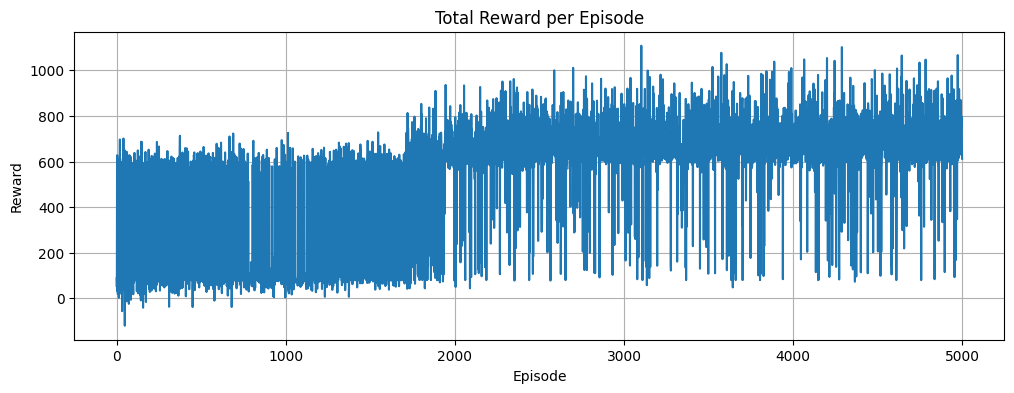

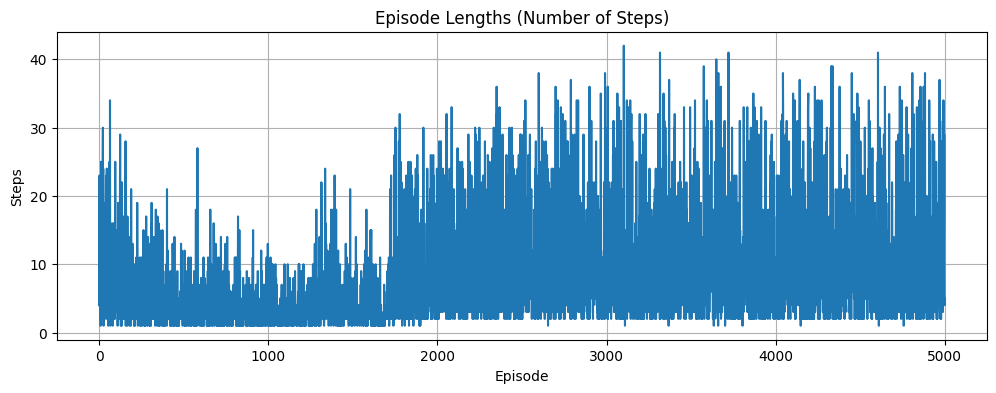

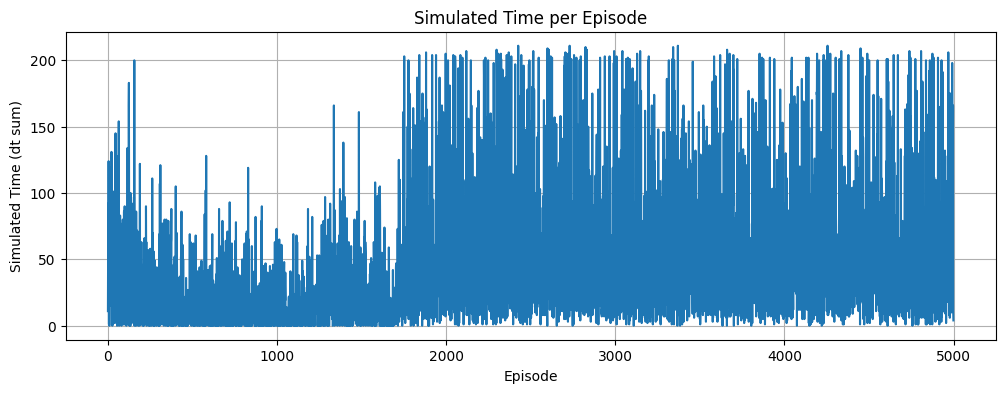

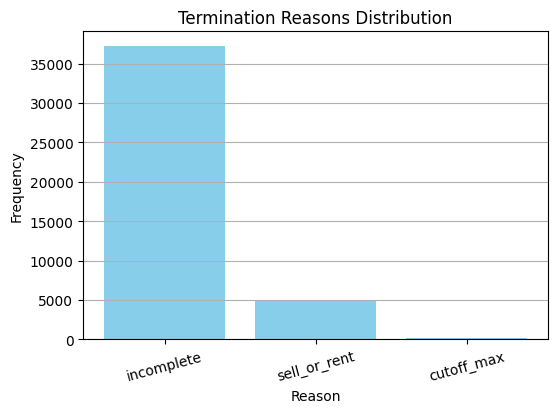

In [12]:
import matplotlib.pyplot as plt
import pickle
import os
from collections import Counter

# Path where everything was saved
save_path = "/kaggle/working/"

# Load all metrics
with open(os.path.join(save_path, "rewards_per_episode.pkl"), "rb") as f:
    rewards_per_episode = pickle.load(f)

with open(os.path.join(save_path, "episode_lengths_steps.pkl"), "rb") as f:
    episode_lengths_steps = pickle.load(f)

with open(os.path.join(save_path, "episode_lengths_time.pkl"), "rb") as f:
    episode_lengths_time = pickle.load(f)

with open(os.path.join(save_path, "termination_reasons.pkl"), "rb") as f:
    termination_reasons = pickle.load(f)

# --- Plot 1: Reward per Episode ---
plt.figure(figsize=(12, 4))
plt.plot(rewards_per_episode)
plt.title("Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

# --- Plot 2: Episode Lengths (Steps) ---
plt.figure(figsize=(12, 4))
plt.plot(episode_lengths_steps)
plt.title("Episode Lengths (Number of Steps)")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.grid(True)
plt.show()

# --- Plot 3: Simulated Time per Episode ---
plt.figure(figsize=(12, 4))
plt.plot(episode_lengths_time)
plt.title("Simulated Time per Episode")
plt.xlabel("Episode")
plt.ylabel("Simulated Time (dt sum)")
plt.grid(True)
plt.show()

# --- Plot 4: Termination Reasons Distribution ---
reason_counts = Counter(termination_reasons)
plt.figure(figsize=(6, 4))
plt.bar(reason_counts.keys(), reason_counts.values(), color='skyblue')
plt.title("Termination Reasons Distribution")
plt.xlabel("Reason")
plt.ylabel("Frequency")
plt.grid(True, axis='y')
plt.xticks(rotation=15)
plt.show()


In [13]:
weights = agent.model.get_weights()
with open("model_weights.pkl", "wb") as f:
    pickle.dump(weights, f)


In [14]:
import pickle
import numpy as np

model_weights_path = "model_weights.pkl"

# 1) Load via pickle, since you dumped with pickle.dump()
with open(model_weights_path, "rb") as f:
    model_weights = pickle.load(f)

# 2) Confirm type
print("Loaded object type:", type(model_weights))
print("Number of arrays:", len(model_weights))
print()

# 3) Summarize each array
for idx, arr in enumerate(model_weights):
    arr = np.array(arr)   # ensure it’s a NumPy array
    print(f"— Array {idx}: shape={arr.shape}, dtype={arr.dtype}, "
          f"min={arr.min():.4f}, max={arr.max():.4f}, mean={arr.mean():.4f}")


Loaded object type: <class 'list'>
Number of arrays: 6

— Array 0: shape=(38, 64), dtype=float32, min=-0.6358, max=0.9131, mean=0.1932
— Array 1: shape=(64,), dtype=float32, min=0.2010, max=0.5464, mean=0.4853
— Array 2: shape=(64, 64), dtype=float32, min=-0.7280, max=0.9049, mean=0.2730
— Array 3: shape=(64,), dtype=float32, min=-0.0526, max=0.4362, mean=0.2753
— Array 4: shape=(64, 24), dtype=float32, min=-0.7322, max=0.7391, mean=0.1673
— Array 5: shape=(24,), dtype=float32, min=0.0522, max=0.1930, mean=0.1353


In [15]:
# re-instantiate the agent (so it builds the graph)
agent = DQNAgent(state_size=state_size, action_size=action_size)

# load the weights you previously saved
agent.model.load_weights("/kaggle/working/DQN_model.weights.h5")
agent.target_model.load_weights("/kaggle/working/DQN_model_target.weights.h5")

# now agent.model is ready to predict
agent.model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 64)                  │           2,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 24)                  │           1,560 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,216 (32.09 KB)

 Trainable params: 8,216 (32.09 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
def model_predict(agent, env, state):
    """
    Given a trained DQNAgent and an environment, encode `state`, 
    run the network, and pick the legal action with highest Q-value.
    """
    # 1) Encode the state
    s_enc = np.array(env.state_encod(state), dtype=np.float32).reshape(1, agent.state_size)

    # 2) Get all Q-values from the main network
    q_vals = agent.model.predict(s_enc, verbose=0)[0]

    # 3) Find which actions are allowed right now
    legal_idxs = env.requests(state)               # ← single return

    # 4) Pick the legal action with highest Q
    best_rel   = np.argmax([q_vals[i] for i in legal_idxs])
    best_idx   = legal_idxs[best_rel]
    best_action= env.action_space[best_idx]

    # 5) Print a little summary
    print("\n" + "*"*10 + " Model Inference " + "*"*10)
    print(f" State: {state}")
    print(f" Full Q-values: {q_vals}")
    print(f" Legal action indices: {legal_idxs}")
    print(f" Chosen index: {best_idx} → action {best_action}")
    print("*"*36 + "\n")

    return best_action


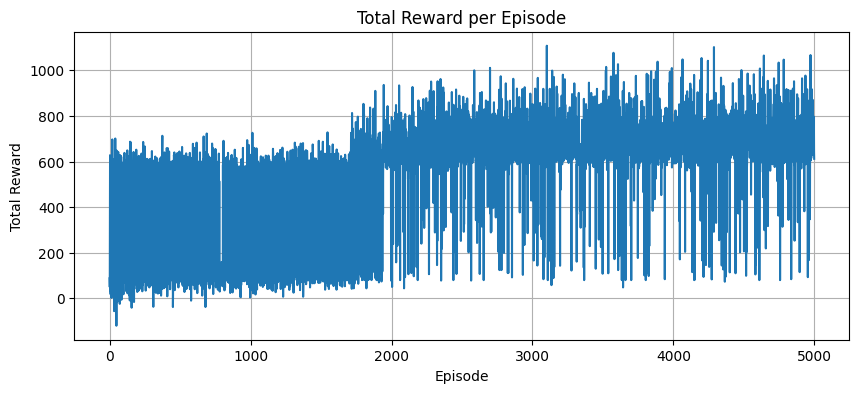

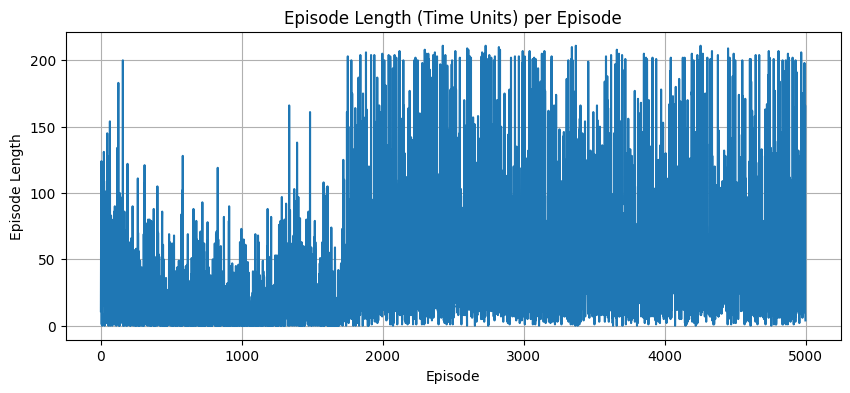

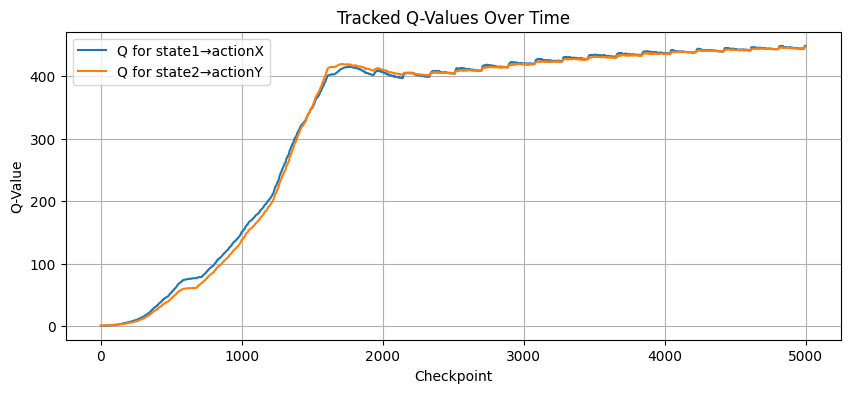

In [17]:
# 1) Total Reward per Episode
with open(os.path.join(save_path, "rewards_per_episode.pkl"), "rb") as f:
    score_tracked = pickle.load(f)

# 2) Episode Length (Time Units) per Episode
with open(os.path.join(save_path, "episode_lengths_time.pkl"), "rb") as f:
    episode_lengths = pickle.load(f)

# 3) Q-value traces
with open(os.path.join(save_path, "tracking_arrays.pkl"), "rb") as f:
    tracking = pickle.load(f)
agent.states_tracked_1 = tracking['states_tracked_1']
agent.states_tracked_2 = tracking['states_tracked_2']

# Plot 1: Reward vs. Episodes
plt.figure(figsize=(10,4))
plt.plot(score_tracked)
plt.title("Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

# Plot 2: Episode Length vs. Episodes
plt.figure(figsize=(10,4))
plt.plot(episode_lengths)
plt.title("Episode Length (Time Units) per Episode")
plt.xlabel("Episode")
plt.ylabel("Episode Length")
plt.grid(True)
plt.show()

# Plot 3: Tracked Q-Values
plt.figure(figsize=(10,4))
plt.plot(agent.states_tracked_1, label="Q for state1→actionX")
plt.plot(agent.states_tracked_2, label="Q for state2→actionY")
plt.title("Tracked Q-Values Over Time")
plt.xlabel("Checkpoint")
plt.ylabel("Q-Value")
plt.legend()
plt.grid(True)
plt.show()


In [18]:
test_state = (3, 3, 4, 0, 1)
model_predict(agent, env, test_state)



********** Model Inference **********
 State: (3, 3, 4, 0, 1)
 Full Q-values: [ 80.81321 281.42636 255.24261 450.00583 292.1813  279.94614 264.7553
 282.21326 275.48706 296.68018 282.7154  284.25156 276.2108  289.58853
 284.2455  284.59534 273.07788 293.98428 301.0066  303.35052 261.33057
 283.81726 264.1644  283.8653 ]
 Legal action indices: [0, 1, 6, 16, 8]
 Chosen index: 1 → action idle
************************************



'idle'

In [19]:
## Model Prediction: Example 2:  state (1,10,3)
test_state = (1,10,3, 0, 1)
model_predict(agent, env, test_state)



********** Model Inference **********
 State: (1, 10, 3, 0, 1)
 Full Q-values: [ 80.626175 278.63806  251.32982  449.79617  286.76816  280.2737
 263.51273  276.35904  279.22668  310.68552  281.96866  285.76654
 269.44046  281.44592  275.49387  280.1265   271.8112   284.00287
 291.1466   297.7002   262.69897  284.05005  263.22574  289.78165 ]
 Legal action indices: [0, 1, 16, 20, 9, 18, 22, 6, 14, 15, 8, 17]
 Chosen index: 9 → action (1, 2)
************************************



(1, 2)

In [20]:
## Model Prediction: Example 3: state (2,2,5)
test_state = (3, 3, 4, 0, 1)
model_predict(agent, env, test_state)



********** Model Inference **********
 State: (3, 3, 4, 0, 1)
 Full Q-values: [ 80.81321 281.42636 255.24261 450.00583 292.1813  279.94614 264.7553
 282.21326 275.48706 296.68018 282.7154  284.25156 276.2108  289.58853
 284.2455  284.59534 273.07788 293.98428 301.0066  303.35052 261.33057
 283.81726 264.1644  283.8653 ]
 Legal action indices: [0, 1, 15, 7, 18, 21, 12, 8, 14, 20]
 Chosen index: 18 → action (3, 2)
************************************



(3, 2)

In [21]:
## Model Prediction: Example 4: state (1,1,1)
test_state = (1,1,1, 0, 1)
model_predict(agent, env, test_state)



********** Model Inference **********
 State: (1, 1, 1, 0, 1)
 Full Q-values: [ 80.30631 280.37097 251.48622 448.85413 286.6084  279.29312 263.84445
 277.53757 276.75665 309.595   282.98328 284.45486 271.85162 291.14673
 279.3478  280.97278 271.53564 283.75882 291.73474 294.1428  267.7172
 285.02832 264.79486 290.10156]
 Legal action indices: [0, 1, 13, 7, 14, 12, 18, 5, 11, 20, 9, 15, 17, 23, 10]
 Chosen index: 9 → action (1, 2)
************************************



(1, 2)

In [22]:
# For Sample state_action pair 1: State (2,4,6), Action (2,3)
agent.states_tracked_1

[0.69230527,
 0.69230527,
 0.69230527,
 0.69230527,
 0.69480705,
 0.7019747,
 0.70430773,
 0.71120197,
 0.7120596,
 0.71288323,
 0.71658444,
 0.7228603,
 0.7222833,
 0.71774524,
 0.714588,
 0.7101067,
 0.7062842,
 0.7059003,
 0.6981645,
 0.6911056,
 0.6899569,
 0.6873015,
 0.68964446,
 0.69019115,
 0.6950596,
 0.6889405,
 0.6883929,
 0.68637097,
 0.68565476,
 0.6809294,
 0.67942166,
 0.67709035,
 0.673826,
 0.6693269,
 0.67778116,
 0.68752587,
 0.7042291,
 0.7098855,
 0.72431296,
 0.7351334,
 0.7536408,
 0.75643045,
 0.7695873,
 0.8035101,
 0.80997247,
 0.835372,
 0.8473959,
 0.85698295,
 0.8820401,
 0.912226,
 0.9258813,
 0.93213886,
 0.9357428,
 0.94246215,
 0.9438941,
 0.9677284,
 0.9895449,
 1.0006571,
 1.0148199,
 1.0325565,
 1.0444272,
 1.0929071,
 1.0990725,
 1.1056929,
 1.1778214,
 1.1926712,
 1.1945618,
 1.2206945,
 1.2397368,
 1.260465,
 1.2647023,
 1.2976297,
 1.3265427,
 1.3511927,
 1.3699931,
 1.3890524,
 1.3931159,
 1.4254626,
 1.4324265,
 1.46282,
 1.4652945,
 1.4864666,

In [23]:
# For Sample state_action pair 2: State (1,2,3), Action (1,2)
agent.states_tracked_2

[0.8430973,
 0.8430973,
 0.8430973,
 0.8430973,
 0.84620166,
 0.8555712,
 0.8585673,
 0.86884964,
 0.8701847,
 0.87152225,
 0.8777116,
 0.89585686,
 0.8985028,
 0.90552855,
 0.90615296,
 0.91068596,
 0.9191198,
 0.92189544,
 0.923504,
 0.92301446,
 0.9235431,
 0.92229563,
 0.95024455,
 0.9576102,
 0.9879821,
 1.010467,
 1.0116135,
 1.0183047,
 1.0212095,
 1.0490752,
 1.062206,
 1.0907601,
 1.1095957,
 1.124364,
 1.1368752,
 1.1492603,
 1.1742597,
 1.1834399,
 1.2004174,
 1.2127218,
 1.2265718,
 1.2292361,
 1.2442766,
 1.2828306,
 1.2901623,
 1.3196185,
 1.3350879,
 1.3435595,
 1.3667177,
 1.389647,
 1.4043554,
 1.4104635,
 1.413812,
 1.4200248,
 1.4214263,
 1.4497324,
 1.468735,
 1.4773177,
 1.490631,
 1.5079192,
 1.5148641,
 1.5375235,
 1.5404062,
 1.5432583,
 1.5768672,
 1.5861737,
 1.5871395,
 1.6012671,
 1.6115582,
 1.6217554,
 1.624393,
 1.6424878,
 1.6612128,
 1.678912,
 1.6880759,
 1.6969527,
 1.7000399,
 1.7271651,
 1.732026,
 1.7496178,
 1.7505872,
 1.762022,
 1.766233,
 1.787

In [24]:
def convergence_graph_q_val(fig_num, state, action, states_tracked):
    plt.figure(fig_num, figsize=(10,4))
    plt.title(f"Convergence of Q_values for state {state} and action {action}", fontsize=14, fontweight='bold')
    xaxis = np.asarray(range(0, len(states_tracked)))
    plt.plot(xaxis,np.asarray(states_tracked))
    plt.ylabel("Q_values", fontsize=13, fontstyle='italic')
    plt.xlabel("No. of Episodes  (step increment of 5)", fontsize=13, fontstyle='italic')
    plt.show()

In [25]:
def convergence_graph_q_val_logscale(fig_num, state, action, states_tracked):
    plt.figure(fig_num, figsize=(10,4))
    plt.title(f"Convergence of Q_values (log scale) for state {state} and action {action}", fontsize=14, fontweight='bold')
    xaxis = np.asarray(range(0, len(states_tracked)))
    plt.yscale('log')
    plt.plot(xaxis,np.asarray(states_tracked))
    plt.ylabel("Q_values (log_scale)", fontsize=13, fontstyle='italic')
    plt.xlabel("No. of Episodes  (step increment of 5)", fontsize=13, fontstyle='italic')
    plt.show()


Tracking Convergence for state-action pair 1: State (2,4,6), Action (2,3)



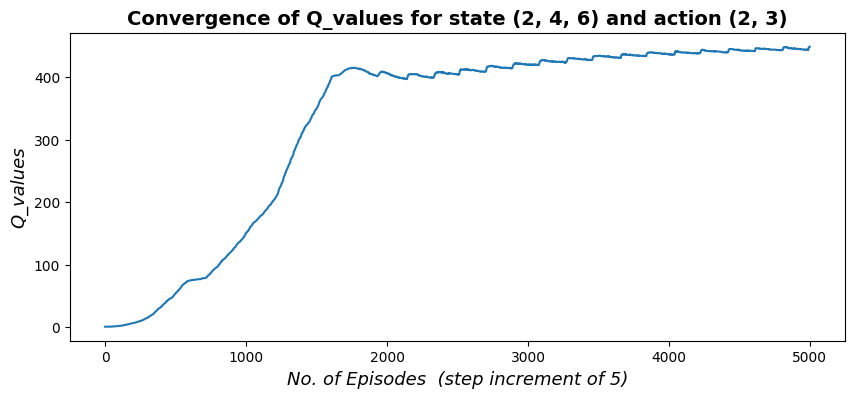

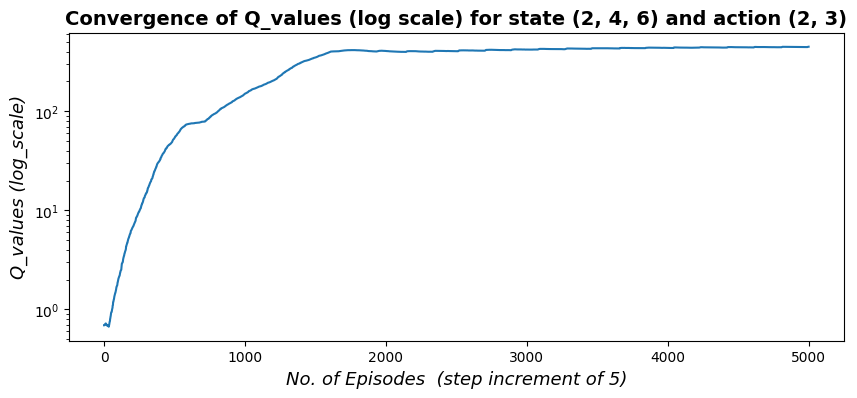




Tracking Convergence for state-action pair 2: State (1,2,3), Action (1,2)



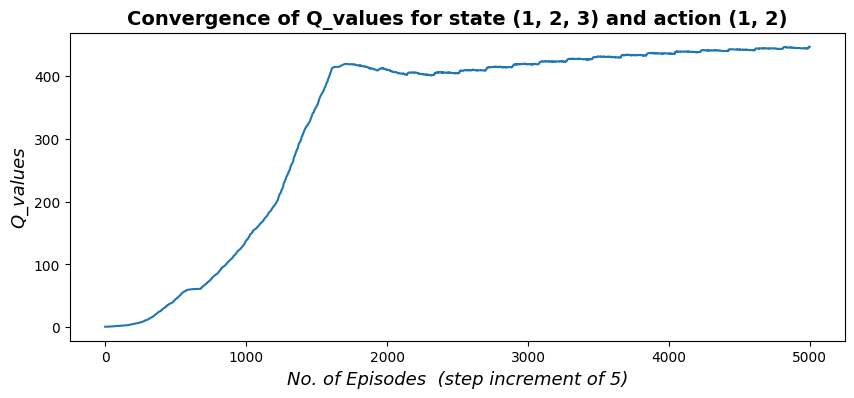

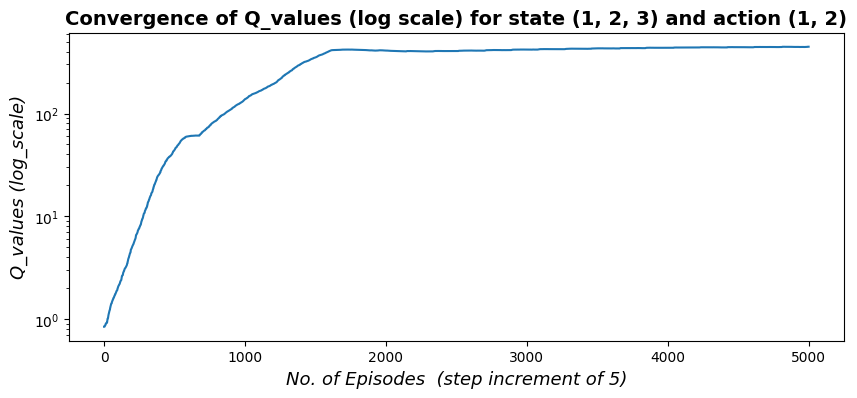

In [26]:
## Convergence Graph 1: For Sample state-action pair 1: State (2,4,6), Action (2,3)
print('\n\033[1m'+"Tracking Convergence for state-action pair 1: State (2,4,6), Action (2,3)\n")
convergence_graph_q_val(fig_num=1, state=(2,4,6), action=(2,3), states_tracked= agent.states_tracked_1)
convergence_graph_q_val_logscale(fig_num=2, state=(2,4,6), action=(2,3), states_tracked= agent.states_tracked_1)

## Convergence Graph 2: For Sample state-action pair 2: State (1,2,3), Action (1,2)
print('\n\n\n\033[1m'+"Tracking Convergence for state-action pair 2: State (1,2,3), Action (1,2)\n")
convergence_graph_q_val(fig_num=3, state=(1,2,3), action=(1,2), states_tracked= agent.states_tracked_2)
convergence_graph_q_val_logscale(fig_num=4, state=(1,2,3), action=(1,2), states_tracked= agent.states_tracked_2)

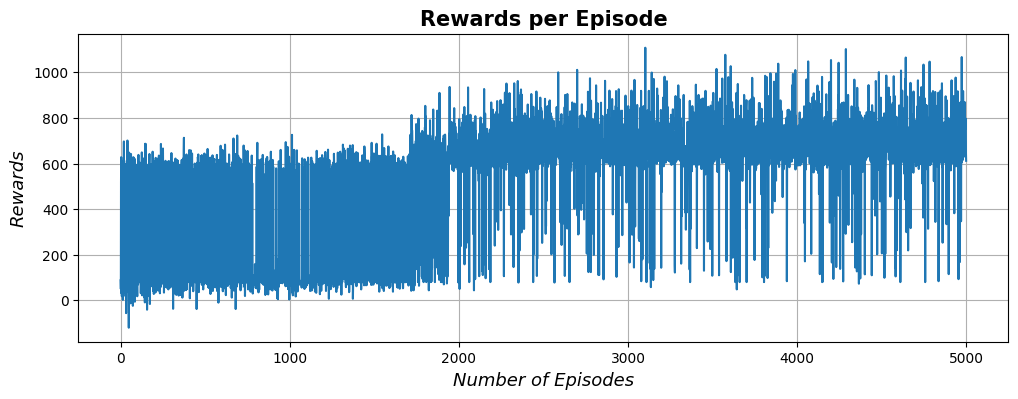

In [27]:
## Rewards (y-axis) vs episodes (x-axis)
plt.figure(5, figsize=(12,4))
plt.title('Rewards per Episode', fontsize=15, fontweight='bold')
xaxis = np.asarray(range(0, len(score_tracked)))
plt.plot(xaxis,np.asarray(score_tracked))
plt.ylabel("Rewards", fontsize=13, fontstyle='italic')
plt.xlabel("Number of Episodes", fontsize=13, fontstyle='italic')
plt.grid(True)
plt.show()

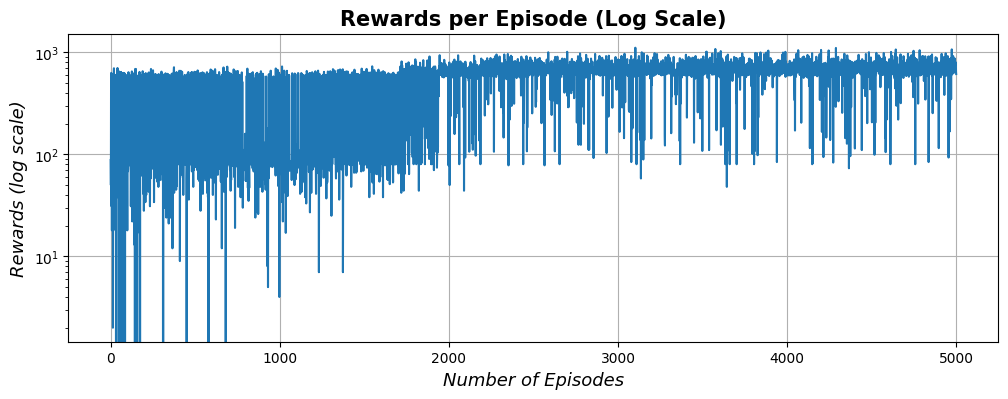

In [28]:
## Rewards (y-axis log scale) vs episodes
plt.figure(6, figsize=(12,4))
plt.title('Rewards per Episode (Log Scale)', fontsize=15, fontweight='bold')
xaxis = np.asarray(range(0, len(score_tracked)))
plt.plot(xaxis,np.asarray(score_tracked))
plt.yscale('log')                                                 ## Log scale: On y-axis
plt.ylabel("Rewards (log scale)", fontsize=13, fontstyle='italic')
plt.xlabel("Number of Episodes", fontsize=13, fontstyle='italic')
plt.grid(True)
plt.show()

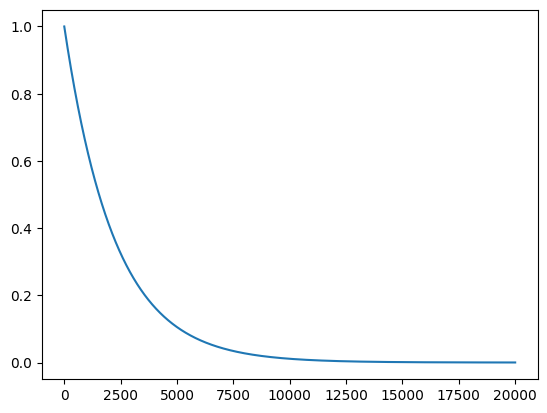

In [29]:
time = np.arange(0,20000)
epsilon = []
for i in range(0,20000):
    epsilon.append(0.0000001 + (1 - 0.0000001) * np.exp(-0.00045*i))

plt.plot(time, epsilon)
plt.show()